<a href="https://colab.research.google.com/github/bhanushri123/Instance-Based-Learning-Model-/blob/main/Copy_of_ibl_model_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
import pygad
import warnings
import os
warnings.filterwarnings("ignore")
import time
import random
from numpy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import re
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# Defining Directory Paths

In [ ]:
parent_path= os.path.abspath(os.pardir) #path of parent directory

In [ ]:
print(parent_path)

D:\Mahavir Dabas\Desktop\iit mandi research work\iit mandi-week 10- cartpole


In [ ]:
data_path=os.path.join(parent_path,"participant_data") #path of the data directory

In [ ]:
data_path

'D:\\Mahavir Dabas\\Desktop\\iit mandi research work\\iit mandi-week 10- cartpole\\participant_data'

In [ ]:
data_list=os.listdir(data_path)

In [ ]:
print("Number of participants in this study: ", len(data_list))

Number of participants in this study:  42


# Testing IBL- All users experiment

In [ ]:
#defining IBL constants

d= 0.5 #deay
s= 0.25 #noise
tau= s*np.power(2, 0.5) #temperature parameter

In [ ]:
vol_id=[]
human_choices=[]
ibl_choices=[]
accuracy_scores=[]
f1_scores=[]

for vol in tqdm(data_list):

    #storing the volunteer id
    vol_id.append(re.sub("_data.xlsx","", vol))

    #reading data
    vol_data_train= pd.read_excel(os.path.join(data_path,vol), sheet_name="Training Data")
    vol_data_test= pd.read_excel(os.path.join(data_path,vol), sheet_name="Testing Data")

    scaler_1= StandardScaler()
    scaler_2= StandardScaler()
    scaler_3= StandardScaler()
    scaler_4= StandardScaler()

    #standardising observations in the training data
    vol_data_train["Obs 1"]=scaler_1.fit_transform(np.array(vol_data_train["Obs 1"]).reshape(len(vol_data_train),1))
    vol_data_train["Obs 2"]=scaler_2.fit_transform(np.array(vol_data_train["Obs 2"]).reshape(len(vol_data_train),1))
    vol_data_train["Obs 3"]=scaler_3.fit_transform(np.array(vol_data_train["Obs 3"]).reshape(len(vol_data_train),1))
    vol_data_train["Obs 4"]=scaler_4.fit_transform(np.array(vol_data_train["Obs 4"]).reshape(len(vol_data_train),1))

    #standardising observations in the test data
    vol_data_test["Obs 1"]=scaler_1.transform(np.array(vol_data_test["Obs 1"]).reshape(len(vol_data_test),1))
    vol_data_test["Obs 2"]=scaler_2.transform(np.array(vol_data_test["Obs 2"]).reshape(len(vol_data_test),1))
    vol_data_test["Obs 3"]=scaler_3.transform(np.array(vol_data_test["Obs 3"]).reshape(len(vol_data_test),1))
    vol_data_test["Obs 4"]=scaler_4.transform(np.array(vol_data_test["Obs 4"]).reshape(len(vol_data_test),1))



    #prepopulating instances
    instances_1= [] #instances of the first action: -1
    instances_2= [] #instances of the 2nd action: 0
    instances_3= [] #instances of the 3rd action: 1

    utility_1= [] #rewards of the first action: -1
    utility_2= [] #rewards of the second action: 0
    utility_3= [] #rewards of the third action: 1


    for trial in range(1,11): #trials 1-10 for each user

        vol_data_train_trial= vol_data_train[vol_data_train["Trial No"]==trial] #getting trial data

        for i in range(len(vol_data_train_trial)):
            #defining reward
            if i==len(vol_data_train_trial)-1: #last move- game ends
                reward=-5
            else:
                reward=0.1

            #identifying action at the time step
            action= vol_data_train_trial.iloc[i]["Action"]
            #taking out the observation at the time ste
            observation= np.array(vol_data_train_trial.iloc[i][3:7])

            if action==-1:
                instances_1.append(observation)
                utility_1.append(reward)

            elif action==0:
                instances_2.append(observation)
                utility_2.append(reward)

            else:
                instances_3.append(observation)
                utility_3.append(reward)

    #oversampling to balance out data
    maximum= np.max([len(instances_1), len(instances_2), len(instances_3)])
    factor_1= round(maximum/len(instances_1),1)
    len_1= len(instances_1)
    instances_1= instances_1* int(factor_1)
    instances_1= instances_1 + [instances_1[i] for i in range(0, int(len_1*(factor_1-int(factor_1))))]
    utility_1= utility_1* int(factor_1)
    utility_1= utility_1 + [utility_1[i] for i in range(0, int(len_1*(factor_1-int(factor_1))))]
    factor_2= round(maximum/len(instances_2),1)
    len_2= len(instances_2)
    instances_2= instances_2* int(factor_2)
    instances_2= instances_2 + [instances_2[i] for i in range(0, int(len_2*(factor_2-int(factor_2))))]
    utility_2= utility_2* int(factor_2)
    utility_2= utility_2 + [utility_2[i] for i in range(0, int(len_2*(factor_2-int(factor_2))))]
    factor_3= round(maximum/len(instances_3),1)
    len_3= len(instances_3)
    instances_3= instances_3* int(factor_3)
    instances_3= instances_3 + [instances_3[i] for i in range(0, int(len_3*(factor_3-int(factor_3))))]
    utility_3= utility_3* int(factor_3)
    utility_3= utility_3 + [utility_3[i] for i in range(0, int(len_3*(factor_3-int(factor_3))))]

    #converting everything to numpy array
    instances_1= np.array(instances_1).astype('float32')
    instances_2= np.array(instances_2).astype('float32')
    instances_3= np.array(instances_3).astype('float32')

    utility_1= np.array(utility_1).astype('float32')
    utility_2= np.array(utility_2).astype('float32')
    utility_3= np.array(utility_3).astype('float32')

    #prepopulating is done here- preparing the test dataset
    vol_test=vol_data_test[vol_data_test["Action"]!=0] #test data eliminating no action case
    human_choice= vol_test["Action"] #taking out thr human choices
    ibl_choice=[] #pyibl choices

    for i in range(len(vol_test)):

        test_query= np.array(vol_test.iloc[i][3:7]) #getting the test query


#___________________________________ DECISION MAKING step 1 - shortlisting ( similarity based ) ________________________________

        #calculating similarities and filtering out instances for each action- cosine sim threshold= 0.85
        sim_1= np.dot(instances_1,test_query)/(norm(instances_1, axis=1)*norm(test_query))
        sim_2= np.dot(instances_2,test_query)/(norm(instances_2, axis=1)*norm(test_query))
        sim_3= np.dot(instances_3,test_query)/(norm(instances_3, axis=1)*norm(test_query))

        #filtering indicies
        filt_1= np.where(sim_1>0.85)
        filt_2= np.where(sim_2>0.85)
        filt_3= np.where(sim_3>0.85)

        #filtered instances that matched a retrieval constraint
        instances_1_filt= instances_1[filt_1]
        instances_2_filt= instances_2[filt_2]
        instances_3_filt= instances_3[filt_3]

        utility_1_filt= utility_1[filt_1]
        utility_2_filt= utility_2[filt_2]
        utility_3_filt= utility_3[filt_3]

        #calc activation values of all instances
        random_draw=np.random.uniform(size= len(instances_1_filt)) #random noise
        act_1= (np.log(np.power(np.ones(len(instances_1_filt)), -d)) -
            [1-(np.dot(instances_1_filt,test_query)/(norm(instances_1_filt, axis=1)*norm(test_query)))] +
            s*np.log(np.divide(1-random_draw, random_draw))) #base level leaning - sim values + noise

        random_draw=np.random.uniform(size= len(instances_2_filt)) #random noise
        act_2= (np.log(np.power(np.ones(len(instances_2_filt)), -d)) -
            [1-(np.dot(instances_2_filt,test_query)/(norm(instances_2_filt, axis=1)*norm(test_query)))] +
            s*np.log(np.divide(1-random_draw, random_draw))) #base level leaning - sim values + noise

        random_draw=np.random.uniform(size= len(instances_3_filt)) #random noise
        act_3= (np.log(np.power(np.ones(len(instances_3_filt)), -d)) -
            [1-(np.dot(instances_3_filt,test_query)/(norm(instances_3_filt, axis=1)*norm(test_query)))] +
            s*np.log(np.divide(1-random_draw, random_draw))) #base level leaning - sim values + noise

        act_1= act_1.astype('float32')
        act_2= act_2.astype('float32')
        act_3= act_3.astype('float32')

        #now calculating ret prob of all instances
        ret_1= np.exp(act_1/tau)/[np.sum(np.exp(act_1/tau))+np.sum(np.exp(act_2/tau))+np.sum(np.exp(act_3/tau))]
        ret_2= np.exp(act_2/tau)/[np.sum(np.exp(act_1/tau))+np.sum(np.exp(act_2/tau))+np.sum(np.exp(act_3/tau))]
        ret_3= np.exp(act_3/tau)/[np.sum(np.exp(act_1/tau))+np.sum(np.exp(act_2/tau))+np.sum(np.exp(act_3/tau))]

        #calculating blended values
        blended_1= np.sum(np.multiply(ret_1, utility_1_filt))
        blended_2= np.sum(np.multiply(ret_2, utility_2_filt))
        blended_3= np.sum(np.multiply(ret_3, utility_3_filt))

        #choosing the final action based on IBL Blended Values
        if blended_1>blended_3:
            ibl_choice.append(-1)

        elif blended_3>blended_1:
            ibl_choice.append(1)

        else:
            ibl_choice.append(np.random.choice([1,-1]))


    #IBL CHOICES MADE, HUMAN CHOICES READ
    human_choices.append(human_choice)
    #storing the choices made by IBL
    ibl_choices.append(ibl_choice)

    #calculating accuracy and f1 scores for each user
    accuracy_scores.append(accuracy_score(human_choice, ibl_choice))
    f1_scores.append(f1_score(human_choice, ibl_choice))

100%|███████████████████████████████████████████████████████████████████████████████| 42/42 [2:04:24<00:00, 177.73s/it]


----------------------------------Summary of Experiment----------------------------------


Average Accuracy:  0.8514171942997723
Average F1 Score:  0.8091849596706485
Total Number of choices made:  46750


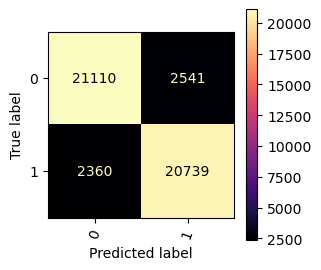



----------------------------------Volunteer ID: 201----------------------------------


Accuracy Score:  0.884
F1 Score:  0.8446428571428571
Number of Choices Made:  1500


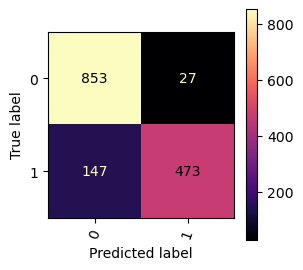



----------------------------------Volunteer ID: 202----------------------------------


Accuracy Score:  0.8881578947368421
F1 Score:  0.8854667949951877
Number of Choices Made:  1064


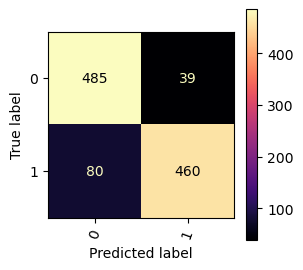



----------------------------------Volunteer ID: 203----------------------------------


Accuracy Score:  0.8852813852813853
F1 Score:  0.8966861598440545
Number of Choices Made:  924


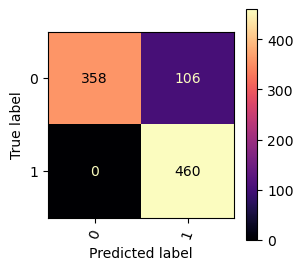



----------------------------------Volunteer ID: 204----------------------------------


Accuracy Score:  0.9140461215932913
F1 Score:  0.9208494208494208
Number of Choices Made:  954


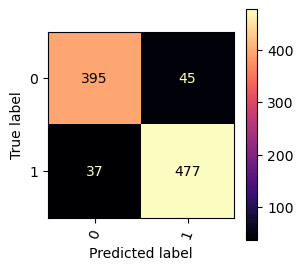



----------------------------------Volunteer ID: 205----------------------------------


Accuracy Score:  0.9388696655132641
F1 Score:  0.942578548212351
Number of Choices Made:  867


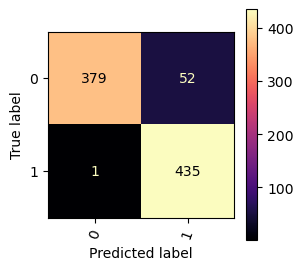



----------------------------------Volunteer ID: 206----------------------------------


Accuracy Score:  0.8740095087163233
F1 Score:  0.8644501278772379
Number of Choices Made:  1262


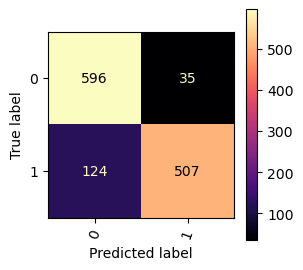



----------------------------------Volunteer ID: 207----------------------------------


Accuracy Score:  0.9576470588235294
F1 Score:  0.9566265060240964
Number of Choices Made:  850


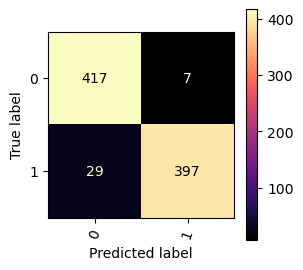



----------------------------------Volunteer ID: 208----------------------------------


Accuracy Score:  0.9097633136094675
F1 Score:  0.9165526675786594
Number of Choices Made:  1352


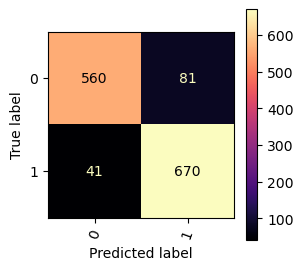



----------------------------------Volunteer ID: 209----------------------------------


Accuracy Score:  0.9380315917375456
F1 Score:  0.9445048966267683
Number of Choices Made:  823


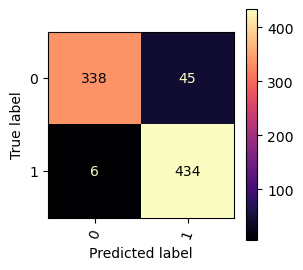



----------------------------------Volunteer ID: 210----------------------------------


Accuracy Score:  0.9363636363636364
F1 Score:  0.9366515837104072
Number of Choices Made:  440


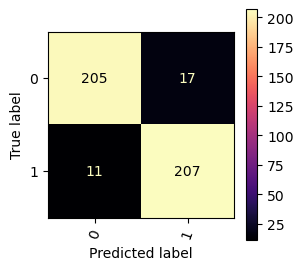



----------------------------------Volunteer ID: 211----------------------------------


Accuracy Score:  0.9325120514193894
F1 Score:  0.9346473029045643
Number of Choices Made:  1867


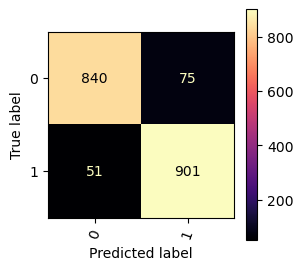



----------------------------------Volunteer ID: 212----------------------------------


Accuracy Score:  0.958041958041958
F1 Score:  0.9567307692307693
Number of Choices Made:  858


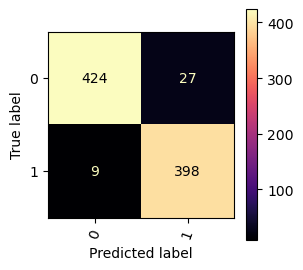



----------------------------------Volunteer ID: 213----------------------------------


Accuracy Score:  0.931592039800995
F1 Score:  0.9263721552878179
Number of Choices Made:  804


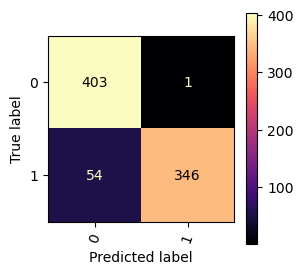



----------------------------------Volunteer ID: 31----------------------------------


Accuracy Score:  0.7740963855421686
F1 Score:  0.09638554216867469
Number of Choices Made:  332


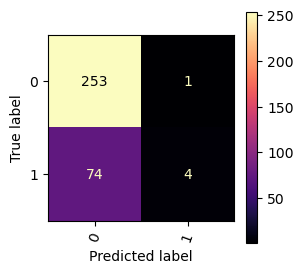



----------------------------------Volunteer ID: 32----------------------------------


Accuracy Score:  0.030303030303030304
F1 Score:  0.05882352941176471
Number of Choices Made:  33


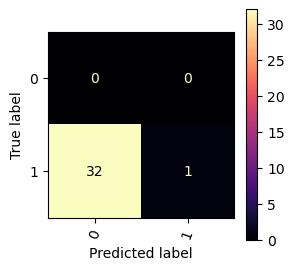



----------------------------------Volunteer ID: 33----------------------------------


Accuracy Score:  0.6658064516129032
F1 Score:  0.6837606837606839
Number of Choices Made:  775


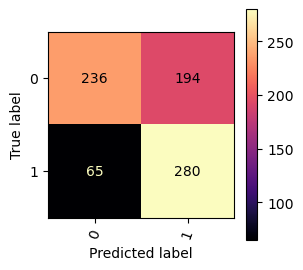



----------------------------------Volunteer ID: 34----------------------------------


Accuracy Score:  0.9243645381277124
F1 Score:  0.9265502709211318
Number of Choices Made:  3226


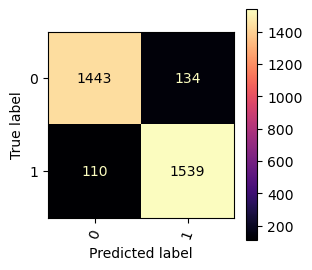



----------------------------------Volunteer ID: 35----------------------------------


Accuracy Score:  0.8156424581005587
F1 Score:  0.849772382397572
Number of Choices Made:  537


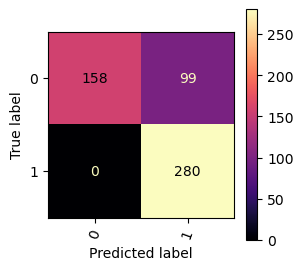



----------------------------------Volunteer ID: 36----------------------------------


Accuracy Score:  0.9588368580060423
F1 Score:  0.9629629629629629
Number of Choices Made:  2648


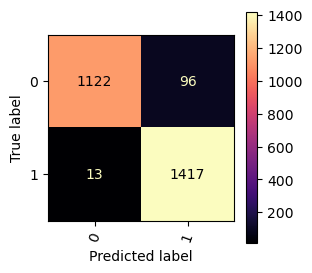



----------------------------------Volunteer ID: 37----------------------------------


Accuracy Score:  0.9557761732851986
F1 Score:  0.9577950043066322
Number of Choices Made:  1108


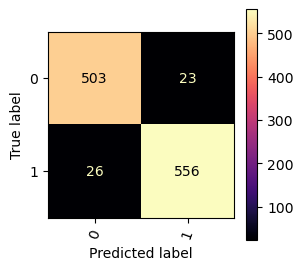



----------------------------------Volunteer ID: 38----------------------------------


Accuracy Score:  0.9231991525423728
F1 Score:  0.9210669569951008
Number of Choices Made:  5664


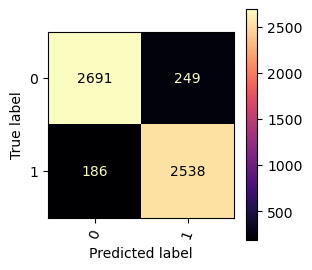



----------------------------------Volunteer ID: 39----------------------------------


Accuracy Score:  0.9161458333333333
F1 Score:  0.9130669546436285
Number of Choices Made:  3840


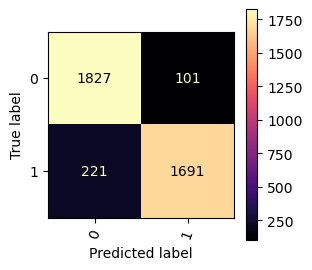



----------------------------------Volunteer ID: 40----------------------------------


Accuracy Score:  0.8992762364294331
F1 Score:  0.894370651486401
Number of Choices Made:  3316


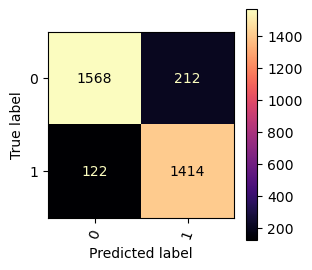



----------------------------------Volunteer ID: 421----------------------------------


Accuracy Score:  0.75
F1 Score:  0.7596899224806201
Number of Choices Made:  124


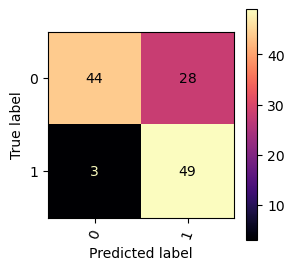



----------------------------------Volunteer ID: 422----------------------------------


Accuracy Score:  0.7598187311178247
F1 Score:  0.6187050359712231
Number of Choices Made:  662


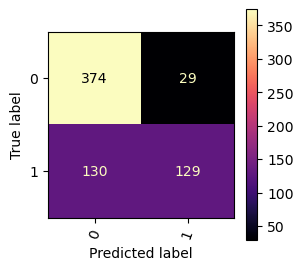



----------------------------------Volunteer ID: 423----------------------------------


Accuracy Score:  0.7603795966785291
F1 Score:  0.7623529411764706
Number of Choices Made:  843


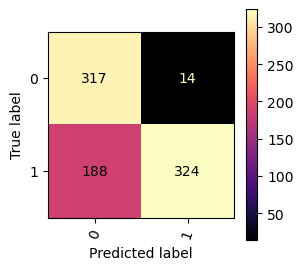



----------------------------------Volunteer ID: 426----------------------------------


Accuracy Score:  0.8488372093023255
F1 Score:  0.0
Number of Choices Made:  86


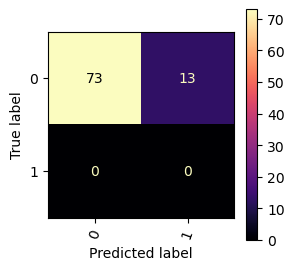



----------------------------------Volunteer ID: 427----------------------------------


Accuracy Score:  0.9643835616438357
F1 Score:  0.9725158562367865
Number of Choices Made:  365


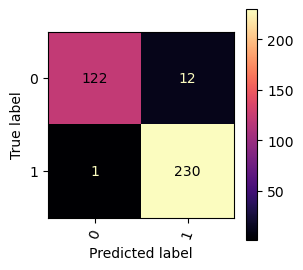



----------------------------------Volunteer ID: 428----------------------------------


Accuracy Score:  0.6784037558685446
F1 Score:  0.6183844011142061
Number of Choices Made:  426


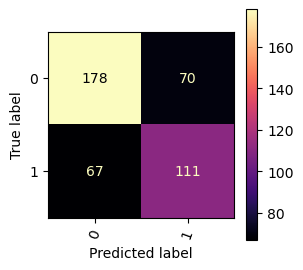



----------------------------------Volunteer ID: 511----------------------------------


Accuracy Score:  0.8564294631710362
F1 Score:  0.8409405255878284
Number of Choices Made:  801


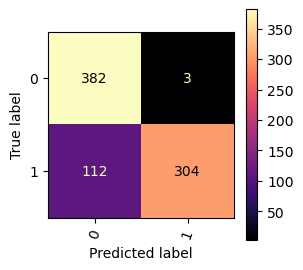



----------------------------------Volunteer ID: 521----------------------------------


Accuracy Score:  0.8614341085271318
F1 Score:  0.8843977364591754
Number of Choices Made:  1032


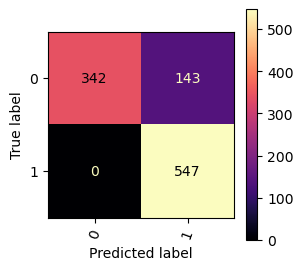



----------------------------------Volunteer ID: 522----------------------------------


Accuracy Score:  0.8598506605399195
F1 Score:  0.8685344827586208
Number of Choices Made:  1741


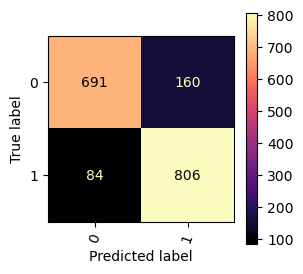



----------------------------------Volunteer ID: 523----------------------------------


Accuracy Score:  0.8220640569395018
F1 Score:  0.8251748251748251
Number of Choices Made:  281


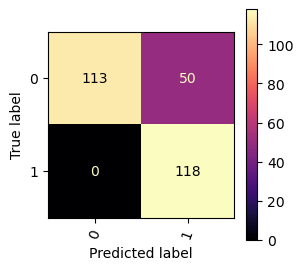



----------------------------------Volunteer ID: 524----------------------------------


Accuracy Score:  0.7352415026833632
F1 Score:  0.5771428571428572
Number of Choices Made:  559


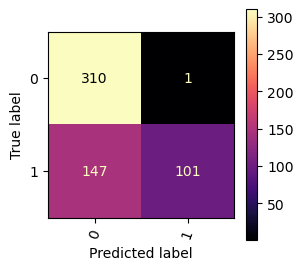



----------------------------------Volunteer ID: 525----------------------------------


Accuracy Score:  0.9388264669163545
F1 Score:  0.9352708058124174
Number of Choices Made:  801


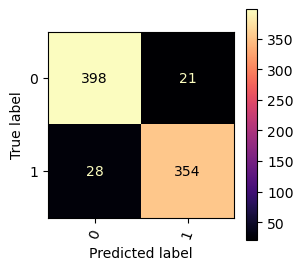



----------------------------------Volunteer ID: 526----------------------------------


Accuracy Score:  0.7972222222222223
F1 Score:  0.8103896103896104
Number of Choices Made:  360


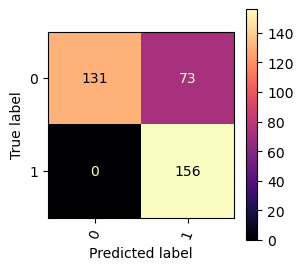



----------------------------------Volunteer ID: 527----------------------------------


Accuracy Score:  0.8354978354978355
F1 Score:  0.8423236514522822
Number of Choices Made:  462


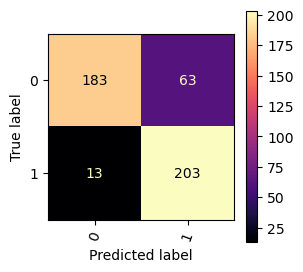



----------------------------------Volunteer ID: 528----------------------------------


Accuracy Score:  0.896011396011396
F1 Score:  0.8843106180665611
Number of Choices Made:  702


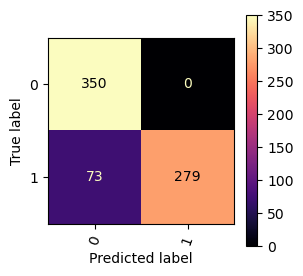



----------------------------------Volunteer ID: 529----------------------------------


Accuracy Score:  0.9146919431279621
F1 Score:  0.91
Number of Choices Made:  422


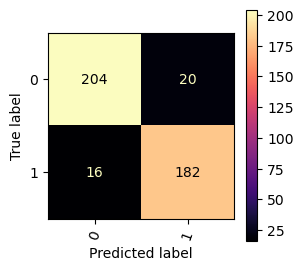



----------------------------------Volunteer ID: 530----------------------------------


Accuracy Score:  0.9012658227848102
F1 Score:  0.9086651053864169
Number of Choices Made:  790


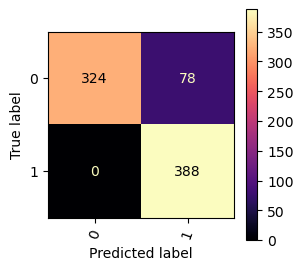



----------------------------------Volunteer ID: 531----------------------------------


Accuracy Score:  0.9077306733167082
F1 Score:  0.9077306733167083
Number of Choices Made:  401


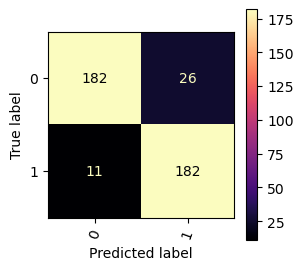



----------------------------------Volunteer ID: 532----------------------------------


Accuracy Score:  0.8596698113207547
F1 Score:  0.8679245283018869
Number of Choices Made:  848


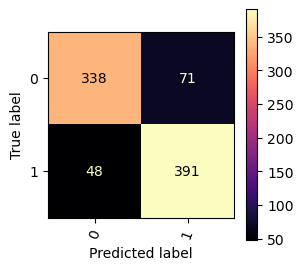

In [ ]:
#Result Analysis
print("----------------------------------Summary of Experiment----------------------------------")
print("\n")
print("Average Accuracy: ", np.mean(accuracy_scores))
print("Average F1 Score: ", np.mean(f1_scores))
print("Total Number of choices made: ", np.sum([len(i) for i in human_choices]))
human_choices_all=[]
for i in range(len(human_choices)):
    human_choices_all+= list(human_choices[i])
ibl_choices_all=[]
for i in range(len(ibl_choices)):
    ibl_choices_all+= list(ibl_choices[i])

disp=ConfusionMatrixDisplay(confusion_matrix(human_choices_all, ibl_choices_all))
fig, ax = plt.subplots(figsize=(3,3))
disp.plot(ax=ax,
          xticks_rotation=70,
          cmap="magma")
plt.show()
print("\n")

#Vol Level Summary
for i in range(len(vol_id)):
    print("----------------------------------Volunteer ID: {}----------------------------------".format(vol_id[i]))
    print("\n")
    print("Accuracy Score: ", accuracy_scores[i])
    print("F1 Score: ", f1_scores[i])
    print("Number of Choices Made: ", len(human_choices[i]))
    disp=ConfusionMatrixDisplay(confusion_matrix(human_choices[i], ibl_choices[i]))
    fig, ax = plt.subplots(figsize=(3,3))
    disp.plot(ax=ax,
              xticks_rotation=70,
              cmap="magma")
    plt.show()
    print("\n")